# Libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from itertools import combinations
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest
from sklearn.naive_bayes import GaussianNB

# Preprocessing

In [2]:
#Importing the data
df_credit = pd.read_csv("german_credit_data.csv", index_col=0)

In [3]:
#Searching for Missings,type of data and also known the shape of data
print(df_credit.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Age               1000 non-null   int64 
 1   Sex               1000 non-null   object
 2   Job               1000 non-null   int64 
 3   Housing           1000 non-null   object
 4   Saving accounts   817 non-null    object
 5   Checking account  606 non-null    object
 6   Credit amount     1000 non-null   int64 
 7   Duration          1000 non-null   int64 
 8   Purpose           1000 non-null   object
 9   Risk              1000 non-null   object
dtypes: int64(4), object(6)
memory usage: 85.9+ KB
None


### Creating an categorical variable to handle with the Age variable

In [4]:
#Let's look the Credit Amount column
interval = (18, 25, 35, 60, 120)

cats = ['Student', 'Young', 'Adult', 'Senior']
df_credit["Age_cat"] = pd.cut(df_credit.Age, interval, labels=cats)


df_good = df_credit[df_credit["Risk"] == 'good']
df_bad = df_credit[df_credit["Risk"] == 'bad']

### Looking the total of values in each categorical feature

In [5]:
print("Purpose : ",df_credit.Purpose.unique())
print("Sex : ",df_credit.Sex.unique())
print("Housing : ",df_credit.Housing.unique())
print("Saving accounts : ",df_credit['Saving accounts'].unique())
print("Risk : ",df_credit['Risk'].unique())
print("Checking account : ",df_credit['Checking account'].unique())
print("Aget_cat : ",df_credit['Age_cat'].unique())

Purpose :  ['radio/TV' 'education' 'furniture/equipment' 'car' 'business'
 'domestic appliances' 'repairs' 'vacation/others']
Sex :  ['male' 'female']
Housing :  ['own' 'free' 'rent']
Saving accounts :  [nan 'little' 'quite rich' 'rich' 'moderate']
Risk :  ['good' 'bad']
Checking account :  ['little' 'moderate' nan 'rich']
Aget_cat :  ['Senior', 'Student', 'Adult', 'Young']
Categories (4, object): ['Student' < 'Young' < 'Adult' < 'Senior']


### Let's do some feature engineering on this values and create variable Dummies of the values

In [6]:
def one_hot_encoder(df, nan_as_category = False):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category, drop_first=True)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

### Transforming the data into Dummy variables

In [7]:
df_credit['Saving accounts'] = df_credit['Saving accounts'].fillna('no_inf')
df_credit['Checking account'] = df_credit['Checking account'].fillna('no_inf')

#Purpose to Dummies Variable
df_credit = df_credit.merge(pd.get_dummies(df_credit.Purpose, drop_first=True, prefix='Purpose'), left_index=True, right_index=True)
#Sex feature in dummies
df_credit = df_credit.merge(pd.get_dummies(df_credit.Sex, drop_first=True, prefix='Sex'), left_index=True, right_index=True)
# Housing get dummies
df_credit = df_credit.merge(pd.get_dummies(df_credit.Housing, drop_first=True, prefix='Housing'), left_index=True, right_index=True)
# Housing get Saving Accounts
df_credit = df_credit.merge(pd.get_dummies(df_credit["Saving accounts"], drop_first=True, prefix='Savings'), left_index=True, right_index=True)
# Housing get Risk
df_credit = df_credit.merge(pd.get_dummies(df_credit.Risk, prefix='Risk'), left_index=True, right_index=True)
# Housing get Checking Account
df_credit = df_credit.merge(pd.get_dummies(df_credit["Checking account"], drop_first=True, prefix='Check'), left_index=True, right_index=True)
# Housing get Age categorical
df_credit = df_credit.merge(pd.get_dummies(df_credit["Age_cat"], drop_first=True, prefix='Age_cat'), left_index=True, right_index=True)

### Deleting the old features

In [8]:
#Excluding the missing columns
del df_credit["Saving accounts"]
del df_credit["Checking account"]
del df_credit["Purpose"]
del df_credit["Sex"]
del df_credit["Housing"]
del df_credit["Age_cat"]
del df_credit["Risk"]
del df_credit['Risk_good']

In [9]:
df_credit['Credit amount'] = np.log(df_credit['Credit amount'])

In [10]:
df_credit.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 0 to 999
Data columns (total 25 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Age                          1000 non-null   int64  
 1   Job                          1000 non-null   int64  
 2   Credit amount                1000 non-null   float64
 3   Duration                     1000 non-null   int64  
 4   Purpose_car                  1000 non-null   uint8  
 5   Purpose_domestic appliances  1000 non-null   uint8  
 6   Purpose_education            1000 non-null   uint8  
 7   Purpose_furniture/equipment  1000 non-null   uint8  
 8   Purpose_radio/TV             1000 non-null   uint8  
 9   Purpose_repairs              1000 non-null   uint8  
 10  Purpose_vacation/others      1000 non-null   uint8  
 11  Sex_male                     1000 non-null   uint8  
 12  Housing_own                  1000 non-null   uint8  
 13  Housing_rent       

# 1. Credit scoring model

In [11]:
#Creating the X and y variables
X = df_credit.drop('Risk_bad', 1).values
y = df_credit["Risk_bad"].values

# Spliting X and y into train and test version
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=42)

/var/folders/sc/sz8h_t_d7tgdbx83thr0wtvr0000gn/T/ipykernel_65578/3954407195.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X = df_credit.drop('Risk_bad', 1).values


In [12]:
# Criando o classificador logreg
GNB = GaussianNB()

# Fitting with train data
model = GNB.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(accuracy_score(y_test,y_pred))
print("\n")
print(confusion_matrix(y_test, y_pred))
print("\n")
print(classification_report(y_test, y_pred))

0.648


[[124  54]
 [ 34  38]]


              precision    recall  f1-score   support

           0       0.78      0.70      0.74       178
           1       0.41      0.53      0.46        72

    accuracy                           0.65       250
   macro avg       0.60      0.61      0.60       250
weighted avg       0.68      0.65      0.66       250



### Let's verify the ROC curve

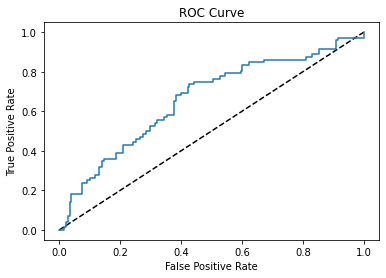

ROC_AUC: 0.6599


In [13]:
#Predicting proba
y_pred_prob = model.predict_proba(X_test)[:,1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

print(f"ROC_AUC: {roc_auc_score(y_test, y_pred_prob):.4f}")

In [14]:
features = []
features.append(('pca', PCA(n_components=2)))
features.append(('select_best', SelectKBest(k=6)))
feature_union = FeatureUnion(features)
# create pipeline
estimators = []
estimators.append(('feature_union', feature_union))
estimators.append(('logistic', GaussianNB()))
model = Pipeline(estimators)
# evaluate pipeline
seed = 7
kfold = KFold(n_splits=10, random_state=seed, shuffle=True)
results = cross_val_score(model, X_train, y_train, cv=kfold)

In [15]:
model.fit(X_train, y_train)
y_pred_prob = model.predict_proba(X_test)[:,1]
y_pred = model.predict(X_test)

print(f"ACC: {accuracy_score(y_test,y_pred):.4f}")
print(f"ROC_AUC: {roc_auc_score(y_test, y_pred_prob):.4f}")

ACC: 0.7200
ROC_AUC: 0.7029


# 2. Fairness measure

## 2.1. Anti-classification

### Gender Anti-classification

In [16]:
#Creating the X and y variables
train_df = df_credit.drop('Risk_bad', 1)
X = train_df.values
y = df_credit["Risk_bad"].values

# Spliting X and y into train and test version
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=42)

gender_idx = train_df.columns.get_loc("Sex_male")
X_train_gender = np.delete(X_train, gender_idx, 1)
X_test_gender = np.delete(X_test, gender_idx, 1)

print(X_train.shape)
print(X_train_gender.shape)
print(X_test.shape)
print(X_test_gender.shape)
print(y_train.shape)
print(y_test.shape)

(750, 24)
(750, 23)
(250, 24)
(250, 23)
(750,)
(250,)


/var/folders/sc/sz8h_t_d7tgdbx83thr0wtvr0000gn/T/ipykernel_65578/12083193.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  train_df = df_credit.drop('Risk_bad', 1)


In [17]:
seed = 7
kfold = KFold(n_splits=10, random_state=seed, shuffle=True)

features1 = []
features1.append(('pca', PCA(n_components=2)))
features1.append(('select_best', SelectKBest(k=6)))
feature_union1 = FeatureUnion(features1)
estimators1 = []
estimators1.append(('feature_union', feature_union1))
estimators1.append(('logistic', GaussianNB()))
model1 = Pipeline(estimators1)
results = cross_val_score(model1, X_train, y_train, cv=kfold)
model1.fit(X_train, y_train)

features2 = []
features2.append(('pca', PCA(n_components=2)))
features2.append(('select_best', SelectKBest(k=6)))
feature_union2 = FeatureUnion(features2)
estimators2 = []
estimators2.append(('feature_union', feature_union2))
estimators2.append(('logistic', GaussianNB()))
model2 = Pipeline(estimators2)
results = cross_val_score(model2, X_train_gender, y_train, cv=kfold)
model2.fit(X_train_gender, y_train)

y_pred = model1.predict(X_test)
y_pred_prob = model1.predict_proba(X_test)[:,1]

y_pred_gender = model2.predict(X_test_gender)
y_pred_prob_gender = model2.predict_proba(X_test_gender)[:,1]

print(f"ACC with plain model: {accuracy_score(y_test, y_pred):.4f}")
print(f"ACC with gender removed model: {accuracy_score(y_test, y_pred_gender):.4f}")
print(f"ACC Gap: {abs(accuracy_score(y_test, y_pred) - accuracy_score(y_test, y_pred_gender)):.4f}")

print(f"\nROC_AUC with plain model: {roc_auc_score(y_test, y_pred):.4f}")
print(f"ROC_AUC with gender removed model: {roc_auc_score(y_test, y_pred_gender):.4f}")
print(f"ROC_AUC: {abs(roc_auc_score(y_test, y_pred_prob) - roc_auc_score(y_test, y_pred_prob_gender)):.4f}")

ACC with plain model: 0.7200
ACC with gender removed model: 0.7200
ACC Gap: 0.0000

ROC_AUC with plain model: 0.6338
ROC_AUC with gender removed model: 0.6338
ROC_AUC: 0.0000


### Age Anti-classification

In [18]:
#Creating the X and y variables
train_df = df_credit.drop('Risk_bad', 1)
X = train_df.values
y = df_credit["Risk_bad"].values

# Spliting X and y into train and test version
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=42)

age_idx = train_df.columns.get_loc("Age")
young_idx = train_df.columns.get_loc("Age_cat_Young")
adult_idx = train_df.columns.get_loc("Age_cat_Adult")
senior_idx = train_df.columns.get_loc("Age_cat_Senior")

X_train_age = np.delete(X_train, [age_idx, young_idx, adult_idx, senior_idx], 1)
X_test_age = np.delete(X_test, [age_idx, young_idx, adult_idx, senior_idx], 1)

print(X_train.shape)
print(X_train_age.shape)
print(X_test.shape)
print(X_test_age.shape)
print(y_train.shape)
print(y_test.shape)

(750, 24)
(750, 20)
(250, 24)
(250, 20)
(750,)
(250,)


/var/folders/sc/sz8h_t_d7tgdbx83thr0wtvr0000gn/T/ipykernel_65578/1534588673.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  train_df = df_credit.drop('Risk_bad', 1)


In [19]:
seed = 7
kfold = KFold(n_splits=10, random_state=seed, shuffle=True)

features1 = []
features1.append(('pca', PCA(n_components=2)))
features1.append(('select_best', SelectKBest(k=6)))
feature_union1 = FeatureUnion(features1)
estimators1 = []
estimators1.append(('feature_union', feature_union1))
estimators1.append(('logistic', GaussianNB()))
model1 = Pipeline(estimators1)
results = cross_val_score(model1, X_train, y_train, cv=kfold)
model1.fit(X_train, y_train)

features2 = []
features2.append(('pca', PCA(n_components=2)))
features2.append(('select_best', SelectKBest(k=6)))
feature_union2 = FeatureUnion(features2)
estimators2 = []
estimators2.append(('feature_union', feature_union2))
estimators2.append(('logistic', GaussianNB()))
model2 = Pipeline(estimators2)
results = cross_val_score(model2, X_train_age, y_train, cv=kfold)
model2.fit(X_train_age, y_train)

y_pred = model1.predict(X_test)
y_pred_prob = model1.predict_proba(X_test)[:,1]

y_pred_age = model2.predict(X_test_age)
y_pred_prob_age = model2.predict_proba(X_test_age)[:,1]

print(f"ACC with plain model: {accuracy_score(y_test, y_pred):.4f}")
print(f"ACC with age removed model: {accuracy_score(y_test, y_pred_gender):.4f}")
print(f"ACC Gap: {abs(accuracy_score(y_test, y_pred) - accuracy_score(y_test, y_pred_gender)):.4f}")

print(f"\nROC_AUC with plain model: {roc_auc_score(y_test, y_pred):.4f}")
print(f"ROC_AUC with age removed model: {roc_auc_score(y_test, y_pred_gender):.4f}")
print(f"ROC_AUC: {abs(roc_auc_score(y_test, y_pred_prob) - roc_auc_score(y_test, y_pred_prob_age)):.4f}")

ACC with plain model: 0.7200
ACC with age removed model: 0.7200
ACC Gap: 0.0000

ROC_AUC with plain model: 0.6338
ROC_AUC with age removed model: 0.6338
ROC_AUC: 0.0208


## 2.2. Group fairness

### Gender Group fairness

In [20]:
#Creating the X and y variables
train_df = df_credit.drop('Risk_bad', 1)
X = train_df.values
y = df_credit["Risk_bad"].values

# Spliting X and y into train and test version
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=42)

gender_idx = train_df.columns.get_loc("Sex_male")

X_test_male = []
y_test_male = []
X_test_female = []
y_test_female = []

for X_, y_ in zip(X_test, y_test):
    if X_[gender_idx] == 1.0:
        X_test_male.append(X_)
        y_test_male.append(y_)
    else:
        X_test_female.append(X_)
        y_test_female.append(y_)
        
print(len(X_test_male), len(y_test_male))
print(len(X_test_female), len(y_test_female))

177 177
73 73


/var/folders/sc/sz8h_t_d7tgdbx83thr0wtvr0000gn/T/ipykernel_65578/672006275.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  train_df = df_credit.drop('Risk_bad', 1)


In [21]:
features = []
features.append(('pca', PCA(n_components=2)))
features.append(('select_best', SelectKBest(k=6)))
feature_union = FeatureUnion(features)
# create pipeline
estimators = []
estimators.append(('feature_union', feature_union))
estimators.append(('logistic', GaussianNB()))
model = Pipeline(estimators)
# evaluate pipeline
seed = 7
kfold = KFold(n_splits=10, random_state=seed, shuffle=True)
results = cross_val_score(model, X_train, y_train, cv=kfold)

model.fit(X_train, y_train)

y_pred_male = model.predict(X_test_male)
y_pred_female = model.predict(X_test_female)

In [22]:
prob_male = sum(y_pred_male) / len(y_pred_male)
prob_female = sum(y_pred_female) / len(y_pred_female)

group_fairness_gap = abs(prob_male - prob_female)
    
print(f"Gender group fairness gap: {group_fairness_gap:.4f}")

Gender group fairness gap: 0.0093


### Age Group fairness

In [23]:
#Creating the X and y variables
train_df = df_credit.drop('Risk_bad', 1)
X = train_df.values
y = df_credit["Risk_bad"].values

# Spliting X and y into train and test version
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=42)

age_idx = train_df.columns.get_loc("Age")
young_idx = train_df.columns.get_loc("Age_cat_Young")
adult_idx = train_df.columns.get_loc("Age_cat_Adult")
senior_idx = train_df.columns.get_loc("Age_cat_Senior")

X_test_student = []
y_test_student = []
X_test_young = []
y_test_young = []
X_test_adult = []
y_test_adult = []
X_test_senior = []
y_test_senior = []

for X_, y_ in zip(X_test, y_test):
    if X_[young_idx] == 1.0:
        X_test_young.append(X_)
        y_test_young.append(y_)
    elif X_[adult_idx] == 1.0:
        X_test_adult.append(X_)
        y_test_adult.append(y_)
    elif X_[senior_idx] == 1.0:
        X_test_senior.append(X_)
        y_test_senior.append(y_)
    else:
        X_test_student.append(X_)
        y_test_student.append(y_)
        
print(len(X_test_student), len(y_test_student))
print(len(X_test_young), len(y_test_young))
print(len(X_test_adult), len(y_test_adult))
print(len(X_test_senior), len(y_test_senior))

51 51
94 94
92 92
13 13


/var/folders/sc/sz8h_t_d7tgdbx83thr0wtvr0000gn/T/ipykernel_65578/2103675554.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  train_df = df_credit.drop('Risk_bad', 1)


In [24]:
features = []
features.append(('pca', PCA(n_components=2)))
features.append(('select_best', SelectKBest(k=6)))
feature_union = FeatureUnion(features)
# create pipeline
estimators = []
estimators.append(('feature_union', feature_union))
estimators.append(('logistic', GaussianNB()))
model = Pipeline(estimators)
# evaluate pipeline
seed = 7
kfold = KFold(n_splits=10, random_state=seed, shuffle=True)
results = cross_val_score(model, X_train, y_train, cv=kfold)

model.fit(X_train, y_train)

y_pred_student = model.predict(X_test_student)
y_pred_young = model.predict(X_test_young)
y_pred_adult = model.predict(X_test_adult)
y_pred_senior = model.predict(X_test_senior)

In [25]:
prob_student = sum(y_pred_student) / len(y_pred_student)
prob_young = sum(y_pred_young) / len(y_pred_young)
prob_adult = sum(y_pred_adult) / len(y_pred_adult)
prob_senior = sum(y_pred_senior) / len(y_pred_senior)
probs = [prob_student, prob_young, prob_adult, prob_senior]

group_fairness_gap = 0.0
for a, b in combinations(probs, 2):
    group_fairness_gap += abs(a - b)
group_fairness_gap /= 6
    
print(f"Age group fairness gap: {group_fairness_gap:.4f}")

Age group fairness gap: 0.2007


## 2.3. Separation

In [26]:
#Creating the X and y variables
train_df = df_credit.drop('Risk_bad', 1)
X = train_df.values
y = df_credit["Risk_bad"].values

# Spliting X and y into train and test version
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=42)

age_idx = train_df.columns.get_loc("Age")
young_idx = train_df.columns.get_loc("Age_cat_Young")
adult_idx = train_df.columns.get_loc("Age_cat_Adult")
senior_idx = train_df.columns.get_loc("Age_cat_Senior")
gender_idx = train_df.columns.get_loc("Sex_male")         # Newly added 

/var/folders/sc/sz8h_t_d7tgdbx83thr0wtvr0000gn/T/ipykernel_65578/3099430699.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  train_df = df_credit.drop('Risk_bad', 1)


### Gender Separation

In [27]:
gender_features = X_test[:, gender_idx]
print(gender_features.shape)

(250,)


In [28]:
def Separation_Gender(protected_attributes, y_pred, y_test):
    X = np.concatenate([np.expand_dims(protected_attributes, -1), np.expand_dims(y_pred, -1)], axis=1)
    num_sizes = len(X)
    fpr_cnt_male = 0 
    fpr_cnt_female = 0
    fnr_cnt_male = 0
    fnr_cnt_female = 0
    true_male = 0
    false_male = 0
    true_female = 0
    false_female = 0
    for i in range(num_sizes):
        # FPR
        # Male and Expected Good but Actual Bad
        #if X[i][0] == 1 and X[i][1] == 0:
        if X[i][0] == 1 and X[i][1] == 1 and y_test[i]== 0: 
            fpr_cnt_male += 1
        # Female and Expected Good but Actual Bad
        elif X[i][0] == 0 and X[i][1] == 1 and y_test[i] == 0:
            fpr_cnt_female += 1
        
        # FNR
        # Male and Expected Bad but Actual Good
        if X[i][0] == 1 and X[i][1] == 0 and y_test[i] == 1:
            fnr_cnt_male += 1
        # Female and Expected Bad but Actual Good
        elif X[i][0] == 0 and X[i][1] == 0 and y_test[i] == 1:
            fnr_cnt_female += 1
            
        # (True/False) and (Male/Female)
        if X[i][0] == 1 and y_test[i] == 1: # TM
            true_male += 1
        elif X[i][0] == 1 and y_test[i] == 0: # FM
            false_male += 1
        elif X[i][0] == 0 and y_test[i] == 1: # TF
            true_female += 1
        elif X[i][0] == 0 and y_test[i] == 0: # FF
            false_female += 1
            
    res = dict()
    res["fpr_male"] = fpr_cnt_male
    res["fpr_female"] = fpr_cnt_female
    res["fnr_male"] = fnr_cnt_male
    res["fnr_female"] = fnr_cnt_female
    res["true_male"] = true_male
    res["false_male"] = false_male
    res["true_female"] = true_female
    res["false_female"] = false_female
            
    return res 

In [29]:
res = Separation_Gender(gender_features, y_pred, y_test)
print("  >> FPR Parity")
print("  >> FPR for Male: {:.4f}".format(res["fpr_male"] / res["false_male"]))
print("  >> FPR for Female: {:.4f}".format(res["fpr_female"] / res["false_female"]))
        
print("\n  >> FNR Parity")
print("  >> FNR for Male: {:.4f}".format((res["fnr_male"] / res["true_male"])))
print("  >> FNR for Female: {:.4f}".format((res["fnr_female"] / res["true_female"])))

  >> FPR Parity
  >> FPR for Male: 0.1654
  >> FPR for Female: 0.1569

  >> FNR Parity
  >> FNR for Male: 0.5800
  >> FNR for Female: 0.5455


### Age Separation

In [30]:
age_one_hot_features = X_test[:, young_idx-1:young_idx+2]
age_one_hot_features = np.concatenate([X_test[:, young_idx].reshape(-1,1),
                                       X_test[:, adult_idx].reshape(-1,1),
                                       X_test[:, senior_idx].reshape(-1,1)],
                                       axis=1)
print(age_one_hot_features.shape)
print(age_one_hot_features[0])

(250, 3)
[0. 0. 0.]


In [31]:
age_separations_dict = {"student": [], "young": [], "adult": [], "senior": []}
print(type(age_separations_dict))

<class 'dict'>


In [32]:
for idx, (feat, pred, test) in enumerate(zip(age_one_hot_features, y_pred, y_test)):
    if feat[0] == 0 and feat[1] == 0 and feat[2] == 0:
        age_separations_dict["student"].append({"feat": feat, "pred":pred, "test":test})
    elif feat[0] == 1 and feat[1] == 0 and feat[2] == 0:
        age_separations_dict["young"].append({"feat": feat, "pred":pred, "test":test})
    elif feat[0] == 0 and feat[1] == 1 and feat[2] == 0:
        age_separations_dict["adult"].append({"feat": feat, "pred":pred, "test":test})
    elif feat[0] == 0 and feat[1] == 0 and feat[2] == 1:
        age_separations_dict["senior"].append({"feat": feat, "pred":pred, "test":test})
    else:
        Assert ("Type Error")

In [33]:
def Separation_Age(sample_data_dict_list):
    num_sizes = len(X)
    fpr_cnt = 0 
    fnr_cnt = 0
    t_cnt = 0
    f_cnt = 0

    for i in range(len(sample_data_dict_list)):
        feat = sample_data_dict_list[i]["feat"]
        y_pred = sample_data_dict_list[i]["pred"]
        y_test = sample_data_dict_list[i]["test"]
        # FPR
        if y_pred == 1 and y_test == 0:
            fpr_cnt += 1
        # FNR
        elif y_pred == 0 and y_test == 1:
            fnr_cnt += 1
            
        # True
        if y_test == 1:
            t_cnt += 1
        elif y_test == 0:
            f_cnt += 1
        
    return fpr_cnt, fnr_cnt, t_cnt, f_cnt

In [34]:
res_separations_list = []
for idx, (key, value) in enumerate(age_separations_dict.items()):
    fpr_cnt, fnr_cnt, t_cnt, f_cnt = Separation_Age(value)
    res_separations_list.append((fpr_cnt, fnr_cnt, t_cnt, f_cnt))

In [35]:
print("  >> Student:")
print("     - FPR Parity: {:.4f}".format(res_separations_list[0][0]/res_separations_list[0][3]))
print("     - FNR Parity: {:.4f}".format(res_separations_list[0][1]/res_separations_list[0][2]))
print("  >> Young:")
print("     - FPR Parity: {:.4f}".format(res_separations_list[1][0]/res_separations_list[1][3]))
print("     - FNR Parity: {:.4f}".format(res_separations_list[1][1]/res_separations_list[1][2]))
print("  >> Adult:")
print("     - FPR Parity: {:.4f}".format(res_separations_list[2][0]/res_separations_list[2][3]))
print("     - FNR Parity: {:.4f}".format(res_separations_list[2][1]/res_separations_list[2][2]))
print("  >> Senior:")
print("     - FPR Parity: {:.4f}".format(res_separations_list[3][0]/res_separations_list[3][3]))
print("     - FNR Parity: {:.4f}".format(res_separations_list[3][1]/res_separations_list[3][2]))

  >> Student:
     - FPR Parity: 0.2941
     - FNR Parity: 0.2353
  >> Young:
     - FPR Parity: 0.1739
     - FNR Parity: 0.6000
  >> Adult:
     - FPR Parity: 0.1045
     - FNR Parity: 0.7200
  >> Senior:
     - FPR Parity: 0.0000
     - FNR Parity: 0.8000


In [36]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.78      0.84      0.81       178
           1       0.52      0.43      0.47        72

    accuracy                           0.72       250
   macro avg       0.65      0.63      0.64       250
weighted avg       0.71      0.72      0.71       250

